In [63]:
import tensorflow as tf
import cv2
import numpy as np
import os
import re
from matplotlib import pyplot

In [89]:
MODEL_PATH_PATTERN = re.compile(r'^efficientdet_d.*')
BBOX_COLOR = (255, 0, 0)

def model_dir(ref_path='.'):
  path = next(filter(lambda p: os.path.isdir(p) and MODEL_PATH_PATTERN.match(p), os.listdir(ref_path)), None)
  assert path is not None, f'Expected model directory matching "{MODEL_PATH_PATTERN.pattern}" in {ref_path}'
  return path

def load_image(path):
  image_bgr = cv2.imread(path)
  b, g, r = cv2.split(image_bgr)
  image_rgb = cv2.merge([r, g, b])
  return image_rgb

def predict(model, image, min_score):
  prediction = model(np.expand_dims(image, 0))
  filter_mask = prediction['detection_scores'][0] > min_score
  return {
    'scores': prediction['detection_scores'][0][filter_mask],
    'classes': prediction['detection_classes'][0][filter_mask],
    'boxes': prediction['detection_boxes'][0][filter_mask]
  }

def tf_box_to_bbox(image, prediction_box):
  shape = tf.shape(image)
  return (
    tf_coord_to_pixel(prediction_box[0], shape[0]),
    tf_coord_to_pixel(prediction_box[1], shape[1]),
    tf_coord_to_pixel(prediction_box[2], shape[0]),
    tf_coord_to_pixel(prediction_box[3], shape[1])
  )

# prediction_boxes are made of float32 tensors indicating a ratio from 0 to 1 so we have to calculate the pixel position
def tf_coord_to_pixel(coord, dim_size):
  return int(tf.cast(coord * tf.cast(dim_size, tf.float32), tf.int32))

def draw_bbox(image, bbox, class_name):
  ymin, xmin, ymax, xmax = bbox
  cv2.rectangle(image, (xmin, ymin), (xmax, ymax), BBOX_COLOR, thickness=2)
  cv2.putText(image, class_name, (xmin+2, ymax-4), cv2.FONT_HERSHEY_SIMPLEX, fontScale=1, color=BBOX_COLOR, thickness=2)

def display_image(image):
  pyplot.imshow(image)
  pyplot.axis('off')
  pyplot.show()




In [48]:
COCO_CLASSNAMES = {
  0: u'__background__',
  1: u'person',
  2: u'bicycle',
  3: u'car',
  4: u'motorcycle',
  5: u'airplane',
  6: u'bus',
  7: u'train',
  8: u'truck',
  9: u'boat',
  10: u'traffic light',
  11: u'fire hydrant',
  12: u'stop sign',
  13: u'parking meter',
  14: u'bench',
  15: u'bird',
  16: u'cat',
  17: u'dog',
  18: u'horse',
  19: u'sheep',
  20: u'cow',
  21: u'elephant',
  22: u'bear',
  23: u'zebra',
  24: u'giraffe',
  25: u'backpack',
  26: u'umbrella',
  27: u'handbag',
  28: u'tie',
  29: u'suitcase',
  30: u'frisbee',
  31: u'skis',
  32: u'snowboard',
  33: u'sports ball',
  34: u'kite',
  35: u'baseball bat',
  36: u'baseball glove',
  37: u'skateboard',
  38: u'surfboard',
  39: u'tennis racket',
  40: u'bottle',
  41: u'wine glass',
  42: u'cup',
  43: u'fork',
  44: u'knife',
  45: u'spoon',
  46: u'bowl',
  47: u'banana',
  48: u'apple',
  49: u'sandwich',
  50: u'orange',
  51: u'broccoli',
  52: u'carrot',
  53: u'hot dog',
  54: u'pizza',
  55: u'donut',
  56: u'cake',
  57: u'chair',
  58: u'couch',
  59: u'potted plant',
  60: u'bed',
  61: u'dining table',
  62: u'toilet',
  63: u'tv',
  64: u'laptop',
  65: u'mouse',
  66: u'remote',
  67: u'keyboard',
  68: u'cell phone',
  69: u'microwave',
  70: u'oven',
  71: u'toaster',
  72: u'sink',
  73: u'refrigerator',
  74: u'book',
  75: u'clock',
  76: u'vase',
  77: u'scissors',
  78: u'teddy bear',
  79: u'hair drier',
  80: u'toothbrush'
}

In [85]:
SAVED_MODEL_DIR = os.path.join(model_dir(), 'saved_model')

eff_det = tf.saved_model.load(SAVED_MODEL_DIR)

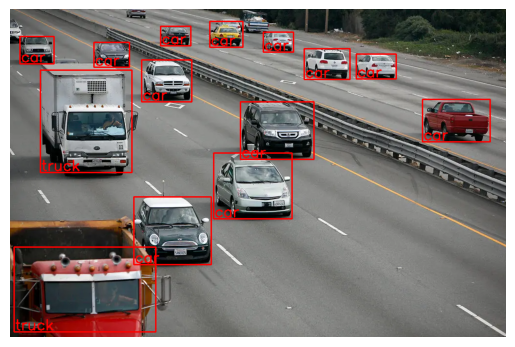

In [90]:
image = load_image('./Highway.jpg')
prediction = predict(eff_det, image, min_score=0.3)

for prediction_box, class_id in zip(prediction['boxes'], prediction['classes']):
  bbox = tf_box_to_bbox(image, prediction_box)
  draw_bbox(image, bbox, COCO_CLASSNAMES[int(class_id)])

display_image(image)


0.3